## Import

In [1]:
import random
import os

import numpy as np
import pandas as pd

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from rdkit import DataStructs
from rdkit.Chem import PandasTools, AllChem

In [2]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)

seed_everything(42) # Seed 고정

## Pre-Processing

In [14]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [15]:
train

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.270,50.590,2.169,301.407,2,1,2,2.172,73.47
2,TRAIN_0002,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.586,80.892,1.593,297.358,5,0,3,1.585,62.45
3,TRAIN_0003,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC...,5.710,2.000,4.771,494.652,6,0,5,3.475,92.60
4,TRAIN_0004,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.270,99.990,2.335,268.310,3,0,1,2.337,42.43
...,...,...,...,...,...,...,...,...,...,...,...
3493,TRAIN_3493,Cn1nc(CNC(=O)Cn2nc(C(F)(F)F)c3c2CCC3)c(Cl)c1Cl,1.556,3.079,3.409,396.195,3,1,5,3.409,64.74
3494,TRAIN_3494,CCn1[nH]cc/c1=N\C(=O)c1nn(-c2ccccc2)c(=O)c2ccc...,35.560,47.630,1.912,359.381,4,1,3,1.844,77.37
3495,TRAIN_3495,CCOC(=O)CCCc1nc2cc(N)ccc2n1C,56.150,1.790,1.941,261.320,3,1,6,2.124,70.14
3496,TRAIN_3496,Nc1cc(C(=O)OCCC2CCOC2=O)cnc1Cl,0.030,2.770,0.989,284.696,5,1,5,0.989,91.51


In [4]:
PandasTools.AddMoleculeColumnToFrame(train,'SMILES','Molecule')
PandasTools.AddMoleculeColumnToFrame(test,'SMILES','Molecule')

In [5]:
def mol2fp(mol):
    fp = AllChem.GetHashedMorganFingerprint(mol, 6, nBits=4096)
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)
    return ar

In [6]:
# FPs column 추가
train["FPs"] = train.Molecule.apply(mol2fp)
test["FPs"] = test.Molecule.apply(mol2fp)

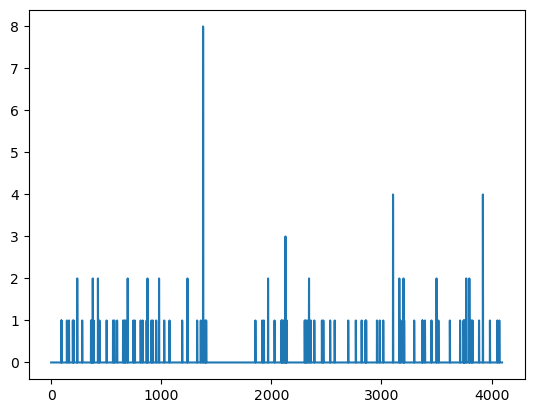

In [12]:
import matplotlib.pyplot as plt
plt.plot(train['FPs'][0])

In [7]:
# 사용할 column만 추출
train = train[['FPs','MLM', 'HLM']]
test = test[['FPs']]

## Custom Dataset

In [8]:
class CustomDataset(Dataset):
    def __init__(self, df, target, transform, is_test=False):
        self.df = df
        self.target = target # HLM or MLM
        self.is_test = is_test # train,valid / test

        self.feature_select = transform
        if not self.is_test: 
            self.fp = self.feature_select.fit_transform(np.stack(df['FPs']))
        else: # valid or test
            self.fp = self.feature_select.transform(np.stack(df['FPs']))

    def __getitem__(self, index):
        fp = self.fp[index]
        if not self.is_test: # test가 아닌 경우(label 존재)
            label = self.df[self.target][index]
            return torch.tensor(fp).float(), torch.tensor(label).float().unsqueeze(dim=-1) # feature, label

        else: # test인 경우
            return torch.tensor(fp).float() # feature
        
    def __len__(self):
        return len(self.df)

In [9]:
transform = VarianceThreshold(threshold=0.05)

train_MLM = CustomDataset(df=train, target='MLM', transform=transform, is_test=False)
train_HLM = CustomDataset(df=train, target='HLM', transform=transform, is_test=False)

input_size = train_MLM.fp.shape[1]
input_size

251

In [10]:
# Hyperparameter
CFG = {'BATCH_SIZE': 256,
       'EPOCHS': 1000,
       'INPUT_SIZE': input_size,
       'HIDDEN_SIZE': 1024,
       'OUTPUT_SIZE': 1,
       'DROPOUT_RATE': 0.8,
       'LEARNING_RATE': 0.001}

In [11]:
# train,valid split
train_MLM_dataset, valid_MLM_dataset = train_test_split(train_MLM, test_size=0.2, random_state=42)
train_HLM_dataset, valid_HLM_dataset = train_test_split(train_HLM, test_size=0.2, random_state=42)

In [12]:
train_MLM_loader = DataLoader(dataset=train_MLM_dataset,
                              batch_size=CFG['BATCH_SIZE'],
                              shuffle=True)

valid_MLM_loader = DataLoader(dataset=valid_MLM_dataset,
                              batch_size=CFG['BATCH_SIZE'],
                              shuffle=False)


train_HLM_loader = DataLoader(dataset=train_HLM_dataset,
                              batch_size=CFG['BATCH_SIZE'],
                              shuffle=True)

valid_HLM_loader = DataLoader(dataset=valid_HLM_dataset,
                              batch_size=CFG['BATCH_SIZE'],
                              shuffle=False)

## Model

In [13]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate, out_size):
        super(Net, self).__init__()
        
        # fc 레이어 3개와 출력 레이어
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc_out = nn.Linear(hidden_size, out_size)
        
        # 정규화
        self.ln1 = nn.LayerNorm(hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)
        self.ln3 = nn.LayerNorm(hidden_size)        
        
        # 활성화 함수
        self.activation = nn.LeakyReLU()
        
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)
     
    def forward(self, x):
        out = self.fc1(x)
        out = self.ln1(out)
        out = self.activation(out)
        out = self.dropout(out)
        
        out = self.fc2(out)
        out = self.ln2(out)
        out = self.activation(out)
        out = self.dropout(out)
        
        out = self.fc3(out)
        out = self.ln3(out)
        out = self.activation(out)
        out = self.dropout(out)

        out = self.fc_out(out)
        return out

In [14]:
model_MLM = Net(CFG['INPUT_SIZE'],CFG['HIDDEN_SIZE'],CFG['DROPOUT_RATE'],CFG['OUTPUT_SIZE'])
model_HLM = Net(CFG['INPUT_SIZE'],CFG['HIDDEN_SIZE'],CFG['DROPOUT_RATE'],CFG['OUTPUT_SIZE'])

In [15]:
criterion = nn.MSELoss()
optimizer_MLM = torch.optim.Adam(model_MLM.parameters(), lr=CFG['LEARNING_RATE'])
optimizer_HLM = torch.optim.Adam(model_HLM.parameters(), lr=CFG['LEARNING_RATE'])

## Training

In [16]:
def train(train_loader, valid_loader, model, criterion, optimizer, epochs):
    model.train()
    
    for epoch in range(epochs):
        running_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            
            output = model(inputs)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        if epoch % 100 == 0:
            valid_loss = 0
            with torch.no_grad():
                for inputs, targets in valid_loader:
                    output = model(inputs)
                    loss = criterion(output, targets)
                    valid_loss += loss.item()
                    
            print(f'Epoch: {epoch}/{epochs}, Train Loss: {running_loss/len(train_loader)}, Valid Loss: {valid_loss/len(valid_HLM_loader)}')
            
            model.train()
    
    return model

In [17]:
print("Training Start: MLM")
model_MLM = train(train_MLM_loader, valid_MLM_loader, model_MLM, criterion, optimizer_MLM, epochs=CFG['EPOCHS'])

print("Training Start: HLM")
model_HLM = train(train_HLM_loader, valid_HLM_loader, model_HLM, criterion, optimizer_HLM, epochs=CFG['EPOCHS'])  

Training Start: MLM
Epoch: 0/1000, Train Loss: 2092.469082919034, Valid Loss: 1900.7300211588542
Epoch: 100/1000, Train Loss: 300.07023481889206, Valid Loss: 1555.84912109375
Epoch: 200/1000, Train Loss: 183.3335224498402, Valid Loss: 1510.0748291015625
Epoch: 300/1000, Train Loss: 141.89285347678444, Valid Loss: 1457.3175048828125
Epoch: 400/1000, Train Loss: 113.00318908691406, Valid Loss: 1575.0428873697917
Epoch: 500/1000, Train Loss: 89.93183968283914, Valid Loss: 1489.7320149739583
Epoch: 600/1000, Train Loss: 92.16542330655184, Valid Loss: 1491.2755940755208
Epoch: 700/1000, Train Loss: 85.29120150479403, Valid Loss: 1575.921875
Epoch: 800/1000, Train Loss: 78.74117417768998, Valid Loss: 1586.5774739583333
Epoch: 900/1000, Train Loss: 69.2516361583363, Valid Loss: 1576.6572265625
Training Start: HLM
Epoch: 0/1000, Train Loss: 3230.5837180397725, Valid Loss: 2635.5509440104165
Epoch: 100/1000, Train Loss: 397.3243685635653, Valid Loss: 1358.5394287109375
Epoch: 200/1000, Train Lo

## Inference

In [18]:
test_MLM = CustomDataset(df=test, target=None, transform=transform, is_test=True)
test_HLM = CustomDataset(df=test, target=None, transform=transform, is_test=True)

test_MLM_loader = DataLoader(dataset=test_MLM,
                             batch_size=CFG['BATCH_SIZE'],
                             shuffle=False)

test_HLM_loader = DataLoader(dataset=test_HLM,
                             batch_size=CFG['BATCH_SIZE'],
                             shuffle=False)

In [19]:
def inference(test_loader, model):
    model.eval()
    preds = []
    
    with torch.no_grad():
        for inputs in test_loader:
            output = model(inputs)
            preds.extend(output.cpu().numpy().flatten().tolist())
    
    return preds

In [20]:
predictions_MLM = inference(test_MLM_loader, model_MLM)
predictions_HLM = inference(test_HLM_loader, model_HLM)

## Submission

In [21]:
submission = pd.read_csv('./sample_submission.csv')
submission

,id,MLM,HLM
0,TEST_000,0,0
1,TEST_001,0,0
2,TEST_002,0,0
3,TEST_003,0,0
4,TEST_004,0,0
...,...,...,...
478,TEST_478,0,0
479,TEST_479,0,0
480,TEST_480,0,0
481,TEST_481,0,0


In [22]:
submission['MLM'] = predictions_MLM
submission['HLM'] = predictions_HLM
submission

,id,MLM,HLM
0,TEST_000,4.429368,32.985760
1,TEST_001,64.407326,85.722000
2,TEST_002,36.571301,55.795212
3,TEST_003,29.255388,66.772362
4,TEST_004,27.548944,89.630684
...,...,...,...
478,TEST_478,49.131546,66.264229
479,TEST_479,88.135956,97.061493
480,TEST_480,33.718052,74.094612
481,TEST_481,40.919796,63.873692


In [23]:
submission.to_csv('baseline_submission.csv', index=False)